### Preprocessing Function

In [62]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.utils import resample


In [63]:
adult_train = 'adult/adult.data'
adult_test = 'adult/adult.test'
churn ='churn/WA_Fn-UseC_-Telco-Customer-Churn.csv'
credit_card = 'creditcard/creditcard.csv'
online = 'online/B1.csv'

RANDOM_STATE = 42

In [64]:
def custom_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
    return X_train, X_val, X_test, y_train, y_val, y_test

def custom_encode(X):
    for col in X.columns:
        if X[col].dtype == 'object':
            X = pd.get_dummies(X, columns=[col], drop_first=True)

    return X

def custom_scale(X):
    for col in X.columns.values:
        if len(X[col].unique()) > 2:
            scalar = StandardScaler()
            X[col] = scalar.fit_transform(X[col].values.reshape(-1, 1))

    return X

def custom_fillna(X):
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].fillna(X[col].mode()[0])
        else:
            X[col] = X[col].fillna(X[col].mean())

    return X

def custom_df_to_X_y(df):
    X = df.iloc[:, :-1]
    y = df.iloc[:, -1]
    return X, y


In [65]:
def preprocess(choice):
    if choice == 'adult':
        adult_df = fetch_ucirepo(id=2)
        X = adult_df.data.features
        y = adult_df.data.targets
        df = pd.concat([X, y], axis=1)
        df.drop_duplicates(inplace=True)

        X, y = custom_df_to_X_y(df)

        X = X.replace(' ?', np.nan)
        X = custom_fillna(X)

        y = np.where(y == '<=50K', 0, y)
        y = np.where(y == '<=50K.', 0, y)
        y = np.where(y == '>50K', 1, y)
        y = np.where(y == '>50K.', 1, y)
        y = y.astype(int)  # Ensure y is integer

        X = custom_encode(X)
        X = custom_scale(X)

        y = y.flatten()
        y = pd.Series(y)
        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val

    elif choice == 'credit_card':
        df = pd.read_csv(credit_card)
        df = df.drop('Time', axis=1)
        #randomly selected 20000 negative samples + all positive samples
        df = pd.concat([df[df['Class'] == 0].sample(20000, random_state=RANDOM_STATE), df[df['Class'] == 1]])
        # shuffle
        df = df.sample(frac=1, random_state=RANDOM_STATE)

        df.drop_duplicates(inplace=True)

        X, y = custom_df_to_X_y(df)

        X = custom_encode(X)
        X = custom_scale(X)

        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val
    
    elif choice == 'churn':
        df = pd.read_csv(churn)
        df = df.drop('customerID', axis=1)

        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

        df = custom_fillna(df)
        df.drop_duplicates(inplace=True)

        df['Churn'] = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

        X, y = custom_df_to_X_y(df)

        X = custom_encode(X)
        X = custom_scale(X)

        # boolean to binary
        for col in X.columns:
            if X[col].dtype == 'bool':
                X[col] = X[col].apply(lambda x: 1 if x == True else 0)

        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val
    
    elif choice == "online":
        df= pd.read_csv(online)
        X = df.iloc[:, :-1]
        y = df.iloc[:, -1]

        X = custom_fillna(X)
        X = custom_encode(X)
        X = custom_scale(X)
        y = y.fillna(y.mode()[0])

        X_train, X_val, X_test, y_train, y_val, y_test = custom_split(X, y)

        return X_train, X_test, X_val, y_train, y_test, y_val

### K-best Features

In [66]:
def k_best_feature(X_train, y_train, X_val, X_test, top_k, choice):
    if choice == 'information_gain':
        mi_scores = mutual_info_classif(X_train, y_train)
        top_features_idx = np.argsort(mi_scores)[::-1][:top_k]  # top k feature index
        # .iloc for indexing df
        X_train = X_train.iloc[:, top_features_idx]
        X_val = X_val.iloc[:, top_features_idx]
        X_test = X_test.iloc[:, top_features_idx]

        return X_train, X_val, X_test

    elif choice == 'correlation':
        correlation = X_train.corrwith(pd.Series(y_train))
        top_features_idx = correlation.abs().nlargest(top_k).index
        # .loc for indexing df
        X_train = X_train.loc[:, top_features_idx]
        X_val = X_val.loc[:, top_features_idx]
        X_test = X_test.loc[:, top_features_idx]

        return X_train, X_val, X_test


### Base Class for Model

In [67]:
class ParentModel:
    def fit(self, X, y):
        raise NotImplementedError("Subclasses should implement this!")

    def predict(self, X):
        raise NotImplementedError("Subclasses should implement this!")

    def predict_proba(self, X):
        raise NotImplementedError("Subclasses should implement this!")
    
    def bootstrap_sample(self, X, y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)

        if isinstance(X, pd.DataFrame):
            return X.iloc[indices], y.iloc[indices]
        else:  
            return X[indices], y[indices]
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_prob = self.predict_proba(X)

        TN, FP, FN, TP = confusion_matrix(y, y_pred).ravel()

        accuracy = accuracy_score(y, y_pred)
        sensitivity = recall_score(y, y_pred)
        specificity = TN / (TN + FP)
        precision = precision_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        auroc = roc_auc_score(y, y_prob)
        auprc = average_precision_score(y, y_prob)

        return accuracy, sensitivity, specificity, precision, f1, auroc, auprc


### Logistic Regression

In [68]:
class LogisticRegression(ParentModel):
    def __init__(self,learning_rate=1, max_epoch=1000, regularization='', l1_lambda=0.01, l2_lambda=0.01):
        self.learning_rate = learning_rate
        self.max_epoch = max_epoch
        self.weights = None
        self.bias = None
        self.regularization = regularization
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda

    def sigmoid(self, z):
        z = np.array(z)
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for epoch in range(self.max_epoch):
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            dw = np.dot(X.T, (y_pred - y)) / X.shape[0]
            db = np.mean(y_pred - y)

            if self.regularization == 'l1':
                dw += self.l1_lambda * np.sign(self.weights)
            elif self.regularization == 'l2':
                dw += self.l2_lambda * self.weights 

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        return y_pred
    
    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        y_pred = self.sigmoid(z)
        return y_pred
    

### Bagging

In [78]:
class Bagging(ParentModel):
    def __init__(self, base_model, n_estimators=9,regularization='', random_seed=RANDOM_STATE, lr=1, l1_lambda=0.01, l2_lambda=0.01, max_epoch=1000):
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.models = []
        self.random_seed = random_seed
        self.regularization = regularization
        self.lr = lr
        self.l1_lambda = l1_lambda
        self.l2_lambda = l2_lambda
        self.max_epoch = max_epoch
        np.random.seed(self.random_seed)

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            model = self.base_model(regularization=self.regularization, l1_lambda=self.l1_lambda, l2_lambda=self.l2_lambda, max_epoch=self.max_epoch, learning_rate=self.lr)
            X_sample, y_sample = self.bootstrap_sample(X, y)
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def get_models(self):
        return self.models
    
    def evaluate(self, X, y):
        accuracies = []
        sensitivities = []
        specificities = []
        precisions = []
        f1_scores = []
        aurocs = []
        auprcs = []

        for model in self.models:
            acc, sen, spe, pre, f1, auroc, auprc = model.evaluate(X, y)
            accuracies.append(acc)
            sensitivities.append(sen)
            specificities.append(spe)
            precisions.append(pre)
            f1_scores.append(f1)
            aurocs.append(auroc)
            auprcs.append(auprc)

        accuracy_mean, accuracy_std = np.mean(accuracies), np.std(accuracies)
        sensitivity_mean, sensitivity_std = np.mean(sensitivities), np.std(sensitivities)
        specificity_mean, specificity_std = np.mean(specificities), np.std(specificities)
        precision_mean, precision_std = np.mean(precisions), np.std(precisions)
        f1_mean, f1_std = np.mean(f1_scores), np.std(f1_scores)
        auroc_mean, auroc_std = np.mean(aurocs), np.std(aurocs)
        auprc_mean, auprc_std = np.mean(auprcs), np.std(auprcs)

        return (accuracy_mean, accuracy_std, 
                sensitivity_mean, sensitivity_std, 
                specificity_mean, specificity_std, 
                precision_mean, precision_std, 
                f1_mean, f1_std, auroc_mean, auroc_std, auprc_mean, auprc_std)


### Stacking

In [70]:
class Stacking(ParentModel):
    def __init__(self, base_model, meta_model, n_estimators=9,models=[],regularization='',random_seed=RANDOM_STATE):
        self.base_model = base_model
        self.meta_model = meta_model(regularization=regularization)
        self.models = models
        self.n_estimators = n_estimators
        self.is_trained = True if len(models) > 0 else False
        self.random_seed = random_seed
        self.regularization = regularization
        np.random.seed(self.random_seed)

    def fit(self, X_train, y_train, X_val, y_val):
        # base models
        base_train_preds = np.zeros((X_val.shape[0], self.n_estimators))
        for i in range(self.n_estimators):
            
            if self.is_trained:
                model = self.models[i]
            else:
                model = self.base_model(regularization=self.regularization)
                X_sample, y_sample = self.bootstrap_sample(X_train, y_train)
                model.fit(X_sample, y_sample)
                self.models.append(model)

            base_train_preds[:, i] = model.predict(X_val)

        # base model predictions + original val set feature
        X_meta_train = np.hstack((X_val, base_train_preds))

        # meta train
        self.meta_model.fit(X_meta_train, y_val)

    def predict(self, X_test):
        # base models preds
        base_test_preds = np.zeros((X_test.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            base_test_preds[:, i] = model.predict(X_test)

        # base model predictions + original test set features
        X_meta_test = np.hstack((X_test, base_test_preds))

        # meta prediction
        return self.meta_model.predict(X_meta_test)
    
    def predict_proba(self, X_test):
        base_test_preds = np.zeros((X_test.shape[0], self.n_estimators))
        for i, model in enumerate(self.models):
            base_test_preds[:, i] = model.predict(X_test)
            
        X_meta_test = np.hstack((X_test, base_test_preds))

        return self.meta_model.predict_proba(X_meta_test)


### Voting

In [71]:
class VotingClassifier(ParentModel):
    def __init__(self, base_model, n_estimators=9,models=[],random_seed=RANDOM_STATE):
        self.base_model = base_model
        self.models = models
        self.n_estimators = n_estimators
        self.is_trained = True if len(models) > 0 else False
        self.random_seed = random_seed
        np.random.seed(self.random_seed)
        
    def fit(self, X_train, y_train):
        for i in range(self.n_estimators):
            if self.is_trained:
                model = self.models[i]
            else:
                model = self.base_model()
                X_sample, y_sample = self.bootstrap_sample(X_train, y_train)
                model.fit(X_sample, y_sample)
                self.models.append(model)
            
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        y_pred = np.mean(predictions, axis=0)
        y_pred = np.where(y_pred > 0.5, 1, 0)
        
        return y_pred
    
    def predict_proba(self, X):
        predictions = np.array([model.predict_proba(X) for model in self.models])
        y_prob = np.mean(predictions, axis=0)
        # y_prob = np.median(predictions, axis=0)

        return y_prob

### Main

In [72]:
def hyperparameter_tuning(X_train, y_train, X_val, y_val):
    best_model = None
    best_f1 = 0
    best_hyperparameters = None

    # change lr and max_epoch
    for lr in [0.001, 0.01, 0.1,1]:
        for max_epoch in [100, 500, 1000]:
            model = LogisticRegression(learning_rate=lr, max_epoch=max_epoch)
            model.fit(X_train, y_train)
            _, _, _, _, f1_score, _, _ = model.evaluate(X_val, y_val)

            if f1_score > best_f1:
                best_f1 = f1_score
                best_model = model
                best_hyperparameters = (lr, max_epoch)

    return best_model, best_hyperparameters


def main_test(choice, lr=1, max_epoch=1000, n_estimators=9, regularization='l2', l1_lambda=0.01, l2_lambda=0.01, k=20, feature_selection='correlation'):

    X_train, X_test, X_val, y_train, y_test, y_val = preprocess(choice)
    #X_train, X_val, X_test = k_best_feature(X_train, y_train, X_val, X_test, 20, 'information_gain')
    X_train, X_val, X_test = k_best_feature(X_train, y_train, X_val, X_test, k, feature_selection)

    print(f'Dataset: {choice}')

    model = Bagging(LogisticRegression, n_estimators=n_estimators, regularization=regularization, l1_lambda=l1_lambda, l2_lambda=l2_lambda, lr=lr, max_epoch=max_epoch)
    model.fit(X_train, y_train)
    accuracy_mean, accuracy_std, sensitivity_mean, sensitivity_std, specificity_mean, specificity_std, precision_mean, precision_std, f1_mean, f1_std, auroc, auroc_std, auprc, auprc_std = model.evaluate(X_test, y_test)

    lr_bagging_metrics = [
         (f"{accuracy_mean:.6f} ± {accuracy_std:.6f}"),
        (f"{sensitivity_mean:.6f} ± {sensitivity_std:.6f}"),
        (f"{specificity_mean:.6f} ± {specificity_std:.6f}"),
        (f"{precision_mean:.6f} ± {precision_std:.6f}"),
        (f"{f1_mean:.6f} ± {f1_std:.6f}"),
        (f"{auroc:.6f} ± {auroc_std:.6f}"),
        (f"{auprc:.6f} ± {auprc_std:.6f}")
    ]

    # Stacking 
    models = model.get_models()
    stacking = Stacking(LogisticRegression, LogisticRegression, n_estimators=9, models=models, regularization=regularization)
    stacking.fit(X_train, y_train, X_val, y_val)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = stacking.evaluate(X_test, y_test)

    stacking_metrics = [accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc]

    # Voting 
    voting = VotingClassifier(LogisticRegression, n_estimators=9, models=models)
    voting.fit(X_train, y_train)
    accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = voting.evaluate(X_test, y_test)

    voting_metrics = [accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc]

    data = {
        "Method": ["LR", "Voting ensemble", "Stacking ensemble"],
        "Accuracy": [lr_bagging_metrics[0], f"{voting_metrics[0]:.6f}", f"{stacking_metrics[0]:.6f}"],
        "Sensitivity": [lr_bagging_metrics[1], f"{voting_metrics[1]:.6f}", f"{stacking_metrics[1]:.6f}"],
        "Specificity": [lr_bagging_metrics[2], f"{voting_metrics[2]:.6f}", f"{stacking_metrics[2]:.6f}"],
        "Precision": [lr_bagging_metrics[3], f"{voting_metrics[3]:.6f}", f"{stacking_metrics[3]:.6f}"],
        "F1-score": [lr_bagging_metrics[4], f"{voting_metrics[4]:.6f}", f"{stacking_metrics[4]:.6f}"],
        "AUROC": [lr_bagging_metrics[5], f"{voting_metrics[5]:.6f}", f"{stacking_metrics[5]:.6f}"],
        "AUPRC": [lr_bagging_metrics[6], f"{voting_metrics[6]:.6f}", f"{stacking_metrics[6]:.6f}"],
    }

    df = pd.DataFrame(data)
    
    pd.set_option('display.colheader_justify', 'center')

    metrics = []
    
    for i, modl in enumerate(model.models):
        accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc = modl.evaluate(X_test, y_test)
        metrics.append([accuracy, sensitivity, specificity, precision, f1_score, auroc, auprc])
        

    return df,metrics



In [80]:
churn_metrics_df,metrics_churn = main_test('churn')
# churn_metrics_df,metrics_churn = test('churn', lr=0.1, max_epoch=1000, n_estimators=9, regularization='l2', l1_lambda=0.01, l2_lambda=0.01, k=20, feature_selection='correlation')
churn_metrics_df

Dataset: churn


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.801977 ± 0.002194,0.508207 ± 0.018722,0.900179 ± 0.005171,0.630024 ± 0.005927,0.562361 ± 0.010936,0.844862 ± 0.001314,0.622140 ± 0.002311
1,Voting ensemble,0.802135,0.502841,0.902184,0.632143,0.560127,0.845351,0.624513
2,Stacking ensemble,0.800712,0.536932,0.888889,0.617647,0.574468,0.839853,0.616814


In [74]:
adult_metrics_df,metrics_adult = main_test('adult')
# adult_metrics_df,metrics_adult = test('adult', lr=0.1, max_epoch=1000, n_estimators=9, regularization='l2', l1_lambda=0.01, l2_lambda=0.01, k=20, feature_selection='correlation')
adult_metrics_df

Dataset: adult


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.841647 ± 0.000845,0.524846 ± 0.006208,0.944226 ± 0.001103,0.752922 ± 0.001924,0.618502 ± 0.003987,0.895662 ± 0.000202,0.742335 ± 0.000829
1,Voting ensemble,0.841647,0.525544,0.944000,0.752398,0.618836,0.895720,0.742479
2,Stacking ensemble,0.841954,0.526801,0.944000,0.752843,0.619857,0.895754,0.743677


In [75]:
credit_metrics_df, metrics_credit_card  = main_test('credit_card')
# credit_metrics_df, metrics_credit_card  = test('credit_card', lr=0.1, max_epoch=1000, n_estimators=9, regularization='l2', l1_lambda=0.01, l2_lambda=0.01, k=20, feature_selection='correlation')
credit_metrics_df

Dataset: credit_card


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.995253 ± 0.000200,0.848765 ± 0.007560,0.999243 ± 0.000000,0.968307 ± 0.000275,0.904587 ± 0.004423,0.993636 ± 0.002241,0.948934 ± 0.002314
1,Voting ensemble,0.995335,0.851852,0.999243,0.968421,0.906404,0.994629,0.949548
2,Stacking ensemble,0.995335,0.851852,0.999243,0.968421,0.906404,0.988471,0.947661


In [79]:
online_metrics_df, metrics_online  = main_test('online')
# online_metrics_df, metrics_online  = test('online', lr=0.1, max_epoch=1000, n_estimators=9, regularization='l2', l1_lambda=0.01, l2_lambda=0.01, k=20, feature_selection='correlation')
online_metrics_df

Dataset: online


,Method,Accuracy,Sensitivity,Specificity,Precision,F1-score,AUROC,AUPRC
0,LR,0.515741 ± 0.047200,0.802288 ± 0.184360,0.278117 ± 0.166337,0.478375 ± 0.032806,0.592733 ± 0.070856,0.474037 ± 0.020524,0.396701 ± 0.008512
1,Voting ensemble,0.560000,0.955882,0.231707,0.507812,0.663265,0.458741,0.390810
2,Stacking ensemble,0.785000,0.860294,0.722561,0.720000,0.783920,0.812892,0.748238


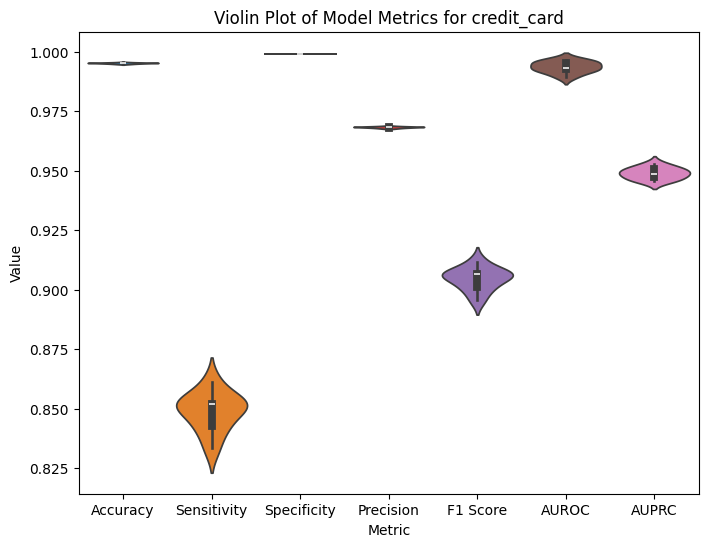

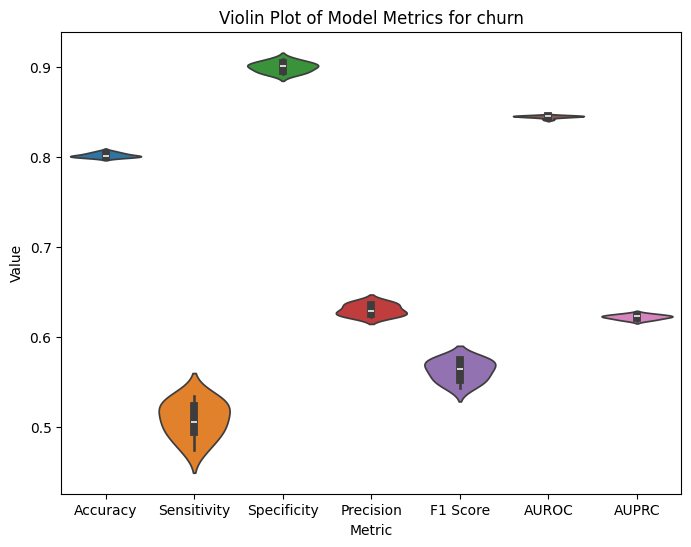

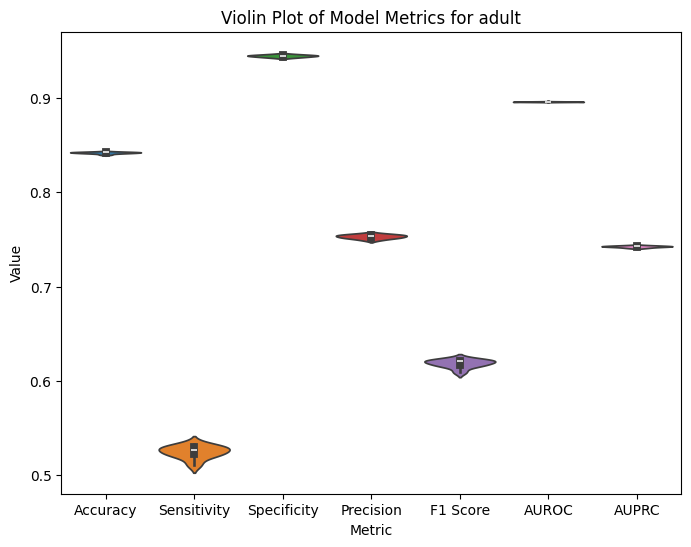

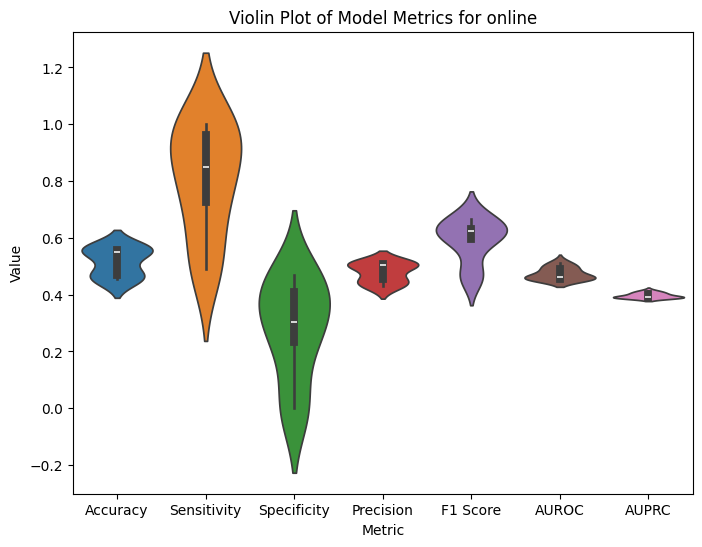

In [77]:
def plot_metrics(metrics, choice):
    metric_names = ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1 Score', 'AUROC', 'AUPRC']
    df = pd.DataFrame(metrics, columns=metric_names)
    plt.figure(figsize=(8, 6))
    sns.violinplot(data=df)
    plt.title('Violin Plot of Model Metrics for' + ' ' + choice)
    plt.ylabel('Value')
    plt.xlabel('Metric')
    plt.show()

plot_metrics(metrics_credit_card, 'credit_card')
plot_metrics(metrics_churn, 'churn')
plot_metrics(metrics_adult, 'adult')
plot_metrics(metrics_online, 'online')